# Group 16: SIT307 Machine Learning Group Project (Assignment 3)

<br>
Dataset Selected: <b>COVID-19 World Vaccination Progress</b>

Found at: https://www.kaggle.com/gpreda/covid-world-vaccination-progress

Collected by: <b>Gabriel Preda</b>

Updated: <b>Daily</b>

Date of download used: <b>17th May 2021</b>

<br><br>
<b>Supplementary data sets found at:</b>

https://www.kaggle.com/tanuprabhu/population-by-country-2020

https://data.worldbank.org/indicator/NY.GDP.MKTP.CD

#### Import libraries used

In [1]:
# import libraries used
import numpy as np
import pandas as pd
pd.set_option('precision', 2)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime
import datetime as dt
pd.set_option('float_format', '{:f}'.format)

import warnings
warnings.filterwarnings('ignore')

### Functions Used in this Notebook

In [2]:
""" 
    Funtion that calculates mean squared error after scaling
    Requires:
        predictions made by model
        Ytest correct outcomes
"""
def MSE(predictions, Ytest, decimal_places):
    # take predictions and Y test set as dataframe
    preds_mse = pd.DataFrame(predictions)
    Ytest_mse = pd.DataFrame(Ytest)
    
    # take the max of prediction and scale all predicitons
    pred_max = preds_mse.max()
    preds_mse = preds_mse / pred_max

    # take the max of Y test and scale all Y test values
    Ytest_max = Ytest_mse.max()
    Ytest_mse = Ytest_mse / Ytest_max 
    
    # return MSE of scaled data
    return round(list(np.mean((preds_mse - Ytest_mse) ** 2))[0], decimal_places)

In [3]:
""" 
    Funtion to convert date in string format to ordinal
    Requires:
        a date in string format (DD/MM/YYYY)
"""
def date_to_ordinal(date):
    # return the date provided as a string in d, m, y to date and then ordinal
    return datetime.strptime(date, '%d/%m/%Y').date().toordinal()

In [4]:
""" 
    Funtion to convert date column in string/object format to ordinal
    Requires:
        a date column in a dataframe
"""
def date_to_ordinal_df(df):
    # convert column to datetime
    df['date'] = pd.to_datetime(df['date'])
    # map all dates to ordinal data
    df['date'] = df['date'].map(dt.datetime.toordinal)
    return df

In [5]:
""" 
    Funtion to convert ordinal number to date format
    Requires:
        an ordinal number (int)
"""
def ordinal_to_datetime(ordinal):
    # convery ordinal to an integer
    ordinal_to_datetime = int(ordinal)
    # change ordinal to a date and return
    ordinal_to_datetime = dt.date.fromordinal(abs(ordinal_to_datetime))
    return ordinal_to_datetime

In [6]:
""" 
    Funtion to convert date column in ordianl format to date
    Requires:
        a date column in a dataframe in ordinal (ints)
"""
def ordinal_to_datetime_arr(arr):
    # set up a new array
    new_arr = []
    # loop through each number passed
    for num in arr:
        #convert number to an int
        num = int(num)
        # cast ordinal to date and append to new array
        new_arr.append(dt.date.fromordinal(abs(num)))
    # return the array as datetime
    return new_arr

In [7]:
""" 
    Funtion that plots linear regression and real data
    Requires:
        X data set
        Y data set
        X test data set
        predictions made by model
"""
def plot_LR(X, Y, Xtest, predictions):
    # Plot real data
    plt.scatter(X, Y,  color='red', s=5)
    #plot linear regression line
    plt.plot(Xtest, predictions, color='blue', linewidth=3)
    # set x ticks
    plt.xticks(rotation=90)

    # show plot
    plt.show()

<br>

### Prediction of date by which provided number of people in a country will be vaccinated

In [8]:
# Read the cleaned dataset to new data frame and country populations
vaccination = pd.read_csv('data/cleaned_vaccination.csv')
country_pop = pd.read_csv('data/population_by_country_2020.csv')

In [9]:
# Select country, date people vaccinated and population columns
vaccination_1 = vaccination[['country', 'date', 'people_vaccinated']]
country_pop = country_pop[['Country (or dependency)','Population (2020)']]

# Print the shape
print(vaccination_1.shape)
print(country_pop.shape)

(17607, 3)
(235, 2)


In [10]:
# Remove the rows with NA values of people vaccinated
vaccination_1 = vaccination_1[vaccination_1['people_vaccinated'].notna()]

# Print the shape after the removal
print(vaccination_1.shape)

(9526, 3)


In [11]:
# Change the object date to date time format and then to ordinal so that it can be used in Linear Regression
date_to_ordinal_df(vaccination_1)

,country,date,people_vaccinated
0,Afghanistan,737843,0.000000
6,Afghanistan,737849,8200.000000
22,Afghanistan,737865,54000.000000
44,Afghanistan,737887,120000.000000
59,Afghanistan,737902,240000.000000
...,...,...,...
17602,Zimbabwe,737918,509274.000000
17603,Zimbabwe,737919,526066.000000
17604,Zimbabwe,737920,529360.000000
17605,Zimbabwe,737921,539526.000000


In [12]:
""" 
    Function finds the date at which for a given country's poppulation would be vaccinated
    Requires:
        -the pandas dataframe being worked on
        -a valid country in string format, and
        -population
"""
def population_vaccinated_by_date(df, country, pop, plot):
    # To check for exceptions during the training of data 
    try:
        # To create a Linear Regression model
        LR = LinearRegression()
    
        # Select the data of a given country
        df = df[df['country'] == country]
    
        # Assign values to X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_vaccinated'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # Train the model
        LR.fit(Xtrain, Ytrain)
    
        # Test on the test set
        predictions = LR.predict(Xtest)

        # Calculate the mean squared error
        mse = MSE(predictions, Ytest, 3)
        
        # Determine the date for a given population 
        expected_date = (LR.intercept_ - pop )/LR.coef_
        
        if plot:
            # Plot the Linear Regression
            plt.title("Date VS Population \n",fontsize = 18,fontweight='bold')
            plt.ylabel("Population in Ten Million\n",fontsize = 15,fontweight='bold')
            plt.xlabel("\nDate",fontsize = 15,fontweight='bold')
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
            
        # Return the expected date for number of people vaccinated of a given country,
        # mean squared error, Y intercept and coeffecient
        return expected_date, mse, LR.intercept_, LR.coef_

    except:
        # If the given country does not have data, print that the country has no data
        # for people vaccinated
        print(country, "has no data for people vaccinated.")
        return False, False, False, False

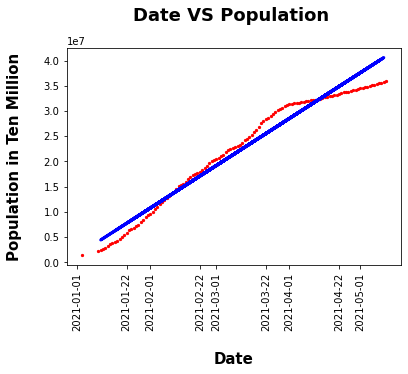


The MSE for this model is 0.008

We predict that by 2021-06-11, United Kingdom will have 50000000 people vaccinated.


In [13]:
# Select a country for analysis
country_num = 'United Kingdom'

# Select the number of people 
pop_num = 50000000

population_country = country_pop.loc[country_pop['Country (or dependency)'] == country_num].iat[0,1]

if(pop_num > population_country):
    date, mse, y_intercept, slope = population_vaccinated_by_date(vaccination_1, country_num, population_country, True)
    print("The entered number of people is greater than the population of {0}, but the total population will be vaccinated by {1}".format((country_num), ordinal_to_datetime(date)))
else:
    # Call the function with the dataset, country name and number of people and plot the result
    date, mse, y_intercept, slope = population_vaccinated_by_date(vaccination_1, country_num, pop_num, True)

    # Print the mean squared error for the model
    print()
    print("The MSE for this model is {0}".format(mse))
    print()

    # Print the prediction
    print("We predict that by {2}, {1} will have {0} people vaccinated.".format(pop_num, country_num, ordinal_to_datetime(date)))

<br>


### Prediction of How Many People a Country Will Have Vaccinated by a Provided Date

Implementing univariant linear regression on people_vaccinated by date for different countries. Providing a country and a date, this section will predict how many people the country provided will have vaccinated by the given date.
<br>

In [14]:
# read in cleaned dataset to new data frame and country populations
vaccination = pd.read_csv('data/cleaned_vaccination.csv')
country_pop = pd.read_csv('data/population_by_country_2020.csv')

In [15]:
# take only the columns of interest
vaccination_2 = vaccination[['country', 'date', 'people_vaccinated']]
country_pop = country_pop[['Country (or dependency)','Population (2020)']]

# show this shape
print(vaccination_2.shape)
print(country_pop.shape)

(17607, 3)
(235, 2)


In [16]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_2 = vaccination_2[vaccination_2['people_vaccinated'].notna()]

# print the new shape
print(vaccination_2.shape)

(9526, 3)


In [17]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_2 = date_to_ordinal_df(vaccination_2)

In [18]:
""" 
    Funtion to determine the number of the given countries population vaccinated at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def numbers_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_vaccinated'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest, 3)
        
        if plot:
            # set labels
            plt.title("Date VS Population\n",fontsize = 18,fontweight='bold')
            plt.ylabel("Population in Ten Millions\n",fontsize = 15,fontweight='bold')
            plt.xlabel("\nDate",fontsize = 15,fontweight='bold')
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the number of people vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print("{0} has no data for people_vaccinated".format(country))
        return False, False, False, False

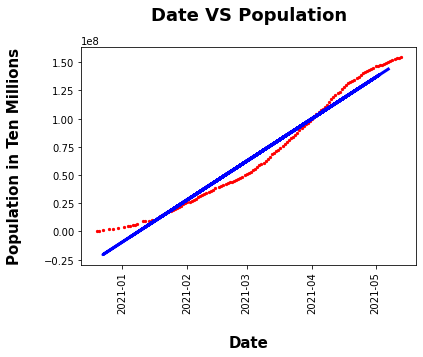

The mean squared error of this model is 0.002.

United States will have 313155539 people fully vaccined by the date 23/09/2021 based on current tracking.


In [19]:
# determine a country to investigate
country_num = 'United States'
# determine a date
date_num = '23/09/2021'

# call function with the dataset, country and date
# store returned values to be printed
pop_at_date, mse_num, y_intercept, slope = numbers_vaccinated_at_date(vaccination_2, country_num, date_num, True)

if pop_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse_num))
    print()
    
    # get population of provided country
    population = country_pop.loc[country_pop['Country (or dependency)'] == country_num].iat[0,1]
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if pop_at_date >= population:
        print("{0} with a population of {1} will be full vaccinated at this date: {2}".format(country_num, round(population), date_num))
        date_target, mse_target, y_intercept, slope = population_vaccinated_by_date(vaccination_2, country_num, population, False)
        print("It is predicted the {0} will fully vaccinate their population on {1}.".format(country_num, ordinal_to_datetime(date_target)))
    else:
        # print data
        print("{0} will have {1} people fully vaccined by the date {2} based on current tracking.".format(country_num, str(round(pop_at_date[0])), date_num))

<br>

### Prediction of What Date a Country Will Have Vaccinated a Provided Percentage of Their Population

Implementing univariant linear regression on people fully vaccinated per hundred by date for different countries. Providing a country and a target percentage, this section will predict what date the country provided will achieve the target percentage of population vaccinated.
<br>

In [20]:
# read in cleaned dataset
vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [21]:
# take only the columns of interest
vaccination_3 = vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]

# show this shape
print(vaccination_3.shape)

(17607, 3)


In [22]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_3 = vaccination_3[vaccination_3['people_fully_vaccinated_per_hundred'].notna()]

# change date object to ordinal to be used in linear regression
date_to_ordinal_df(vaccination_3)

# print the new shape
print(vaccination_3.shape)

(7185, 3)


In [23]:
""" 
    Function to find a date of the given target percentage for the population fully vaccinated
    Requires:
        -the pandas dataframe being worked on
        -a valid country in string format, and
        -target percentage
"""
def date_to_be_target_percentage(df, country, percentage, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_fully_vaccinated_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest, 3)
        
        determin_date = (LR.intercept_ - percentage )/LR.coef_
        
        if plot:
            # set labels
            plt.title("Date VS Population Percentage\n",fontsize = 18,fontweight='bold')
            plt.ylabel("Percentage of Population\n",fontsize = 15,fontweight='bold')
            plt.xlabel("\nDate",fontsize = 15,fontweight='bold')
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the date of the target percentage for the fully vaccinated of country population
        # the mean squared error, the Y intercept and the slope
        return determin_date, mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        #print(country, "has no data for people_fully_vaccinated_per_hundred.")
        return False, False, False, False

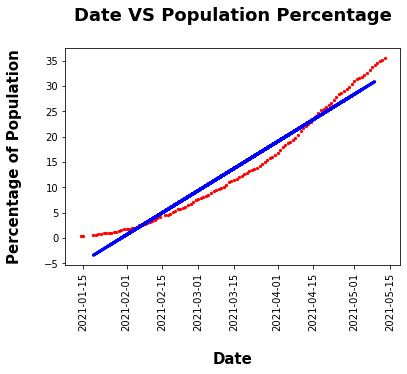

The MSE for this model is 0.005
We predict that 85% of the United States population will be fully immunized by 2021-10-30.


In [24]:
# determine a country to investigate
country_for_perc = 'United States'

# determine a date
target_percentage_of_immunization = 85

# call function with the dataset, country and target_percentage_of_immunization
# store returned values to be printed
date, mse, y_intercept, slope = date_to_be_target_percentage(vaccination_3, country_for_perc, target_percentage_of_immunization, True)

# display MSE
print("The MSE for this model is {0}".format(mse))

# display prediction
print("We predict that {0}% of the {1} population will be fully immunized by {2}.".format(target_percentage_of_immunization, country_for_perc, ordinal_to_datetime(date)))


### Prediction of What Percentage of a Countries Population Will Be Vaccinated by a Given Date

Implementing univariant linear regression on people fully vaccinated per hundred by date for different countries. Providing a country and a date, this section will predict what percentage of the countries population will be fully vaccinated by the provided date. If the date provided gives a value of over 100% (the country has fully vaccinated their population before this date), a further machine learning model will be called to determine what date they are predicted to achieve 100% vaccination.
<br><br>
Some countries don't provide data in the people_fully_vaccinated_per_hundred column. When this is the case the function will return this fact. If this is the case, there is a second machine learning model further down which uses total_vaccinations_per_hundred to determine how many vaccinations have been administered scaled to the population (maximum of 200% for 2 doses for each person).

In [25]:
# read in cleaned dataset to new data frame
vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [26]:
# take only the columns of interest
vaccination_4 = vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]

# show this shape
print(vaccination_4.shape)

(17607, 3)


In [27]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_4 = vaccination_4[vaccination_4['people_fully_vaccinated_per_hundred'].notna()]

# print the new shape
print(vaccination_4.shape)

(7185, 3)


In [28]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_4 = date_to_ordinal_df(vaccination_4)

In [29]:
""" 
    Funtion to determine the percentage of the given countries population fully vaccinated at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def perc_fully_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_fully_vaccinated_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest, 3)
        
        if plot:
            # set labels
            plt.title("Date VS Population Percentage\n",fontsize = 18,fontweight='bold')
            plt.ylabel("Percentage of Population\n",fontsize = 15,fontweight='bold')
            plt.xlabel("\nDate",fontsize = 15,fontweight='bold')
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the percentage of population fully vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print("{0} has no data for people_fully_vaccinated_per_hundred".format(country))
        return False, False, False, False

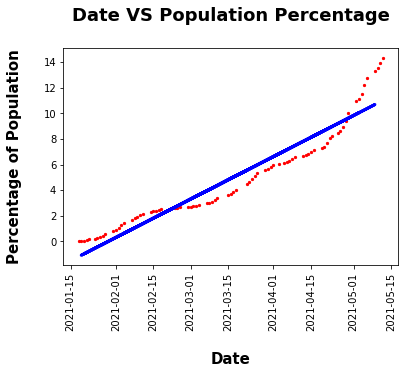

The mean squared error of this model is 0.02.

Spain will have fully vaccined 36.08% of their population by the date 1/1/2022 based on current tracking.


In [30]:
# determine a country to investigate
country_perc_full = 'Spain'
# determine a date
date_perc_full = '1/1/2022'

# call function with the dataset, country and date
# store returned values to be printed
perc_at_date, mse_perc, y_intercept, slope = perc_fully_vaccinated_at_date(vaccination_4, country_perc_full, date_perc_full, True)

if perc_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse_perc))
    print()
    
    # check if country is fully vaccinated and tell user that, or print where the country will be at
    if perc_at_date > 100:
        # if at the date provided the percentage is over 100, call above LR to determine what date 100% will be achieved and display that
        date_100, mse_date, y_intercept, slope = date_to_be_target_percentage(vaccination_4, country_perc_full, 100, False)
        print("It is predicted the {0} will have fully vaccinate their population by {1}.".format(country_perc_full, ordinal_to_datetime(date_100)))
    else:
        # print data
        print("{0} will have fully vaccined {1}% of their population by the date {2} based on current tracking.".format(country_perc_full, str(round(perc_at_date[0], 2)), date_perc_full))

### For Countries Without people_fully_vaccinated_per_hundred Data
<br>
Calculating total number of vaccinations administered at a given date.
<br><br>
This is for countries that don't have data in the dataset for people_fully_vaccinated_per_hundred, so we will use the total number of vaccines administered to get a guide as to how many people may have been vaccinated (2 doses per each member of population so up to 200%)

In [31]:
# read in cleaned dataset to new data frame
vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [32]:
# take only the columns of interest
vaccination_5 = vaccination[['country', 'date', 'total_vaccinations_per_hundred']]
# show this shape
print(vaccination_5.shape)

(17607, 3)


In [33]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_5 = vaccination_5[vaccination_5['total_vaccinations_per_hundred'].notna()]
# print the new shape
print(vaccination_5.shape)

(10251, 3)


In [34]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_5 = date_to_ordinal_df(vaccination_5)

In [35]:
""" 
    Funtion to determine the total vaccinates provided by the given country at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def perc_people_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['total_vaccinations_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest, 3)
        
        if plot:
            # set titles
            plt.title("Date VS Population Percentage\n",fontsize = 18,fontweight='bold')
            plt.ylabel("Percentage of Population\n",fontsize = 15,fontweight='bold')
            plt.xlabel("\nDate",fontsize = 15,fontweight='bold')
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the percentage of population fully vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print(country, "has no data for total_vaccinations_per_hundred.")
        return False, False, False, False

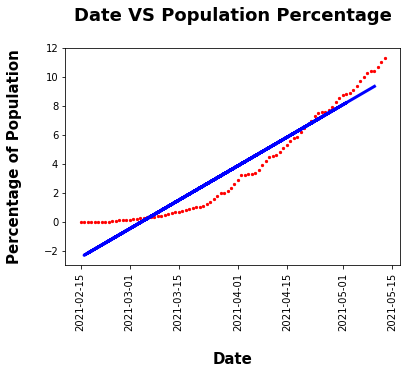

The mean squared error of this model is 0.016.

Australia will have administered 41.17% of vaccines required to their population by the date 22/12/2021 based on current tracking (200% required for 2 doses for each person).


In [36]:
# determine a country to investigate
country_perc_ppl = 'Australia'
# determine a date
date_perc_ppl = '22/12/2021'


# call function with the dataset, country and date
# store returned values to be printed
total_at_date, mse_tot_ppl, y_intercept, slope = perc_people_vaccinated_at_date(vaccination_5, country_perc_ppl, date_perc_ppl, True)
    
if total_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse_tot_ppl))
    print()
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if total_at_date > 200:
        print("{0} is predicted to have administered over 200% of vaccinations to their population by {1}".format(country_perc_ppl, date_perc_ppl))
    else:
        # check if country is full vaccinated and tell user that, or print where the country will be at
        print("{0} will have administered {1}% of vaccines required to their population by the date {2} based on current tracking (200% required for 2 doses for each person).".format(country_perc_ppl, str(round(total_at_date[0], 2)), date_perc_ppl))

<br>

### Use date_to_be_target_percentage() Linear Regression Model/Function to Predict Herd Immunity (70%)

Using the date_to_be_target_percentage() function and linear regression model, predict the date different countries will achieve herd immunity. This can then be combined to get a prediction for world wide vaccinations.
<br>

In [37]:
# Create a new dataframe
pred_70_date = pd.DataFrame(columns=['country','ord_date','mse','y_intercept','slope'])

# Copy unique country value from previous dataframe
pred_70_date['country'] = vaccination_3['country'].unique().copy()

In [38]:
# Calulate each country's predicted herd immunity date
target_percentage_of_immunization = 70

# store in each data frame column the returned values for all countries
pred_70_date['ord_date'] = pred_70_date['country'].map(lambda x : date_to_be_target_percentage(vaccination_3,x,target_percentage_of_immunization, 0)[0])
pred_70_date['mse'] = pred_70_date['country'].map(lambda x : date_to_be_target_percentage(vaccination_3,x,target_percentage_of_immunization, 0)[1])
pred_70_date['y_intercept'] = pred_70_date['country'].map(lambda x : date_to_be_target_percentage(vaccination_3,x,target_percentage_of_immunization, 0)[2])
pred_70_date['slope'] = pred_70_date['country'].map(lambda x : date_to_be_target_percentage(vaccination_3,x,target_percentage_of_immunization, 0)[3])

# print head to see what data looks like depending on if countries have provided this data
pred_70_date.head()

,country,ord_date,mse,y_intercept,slope
0,Afghanistan,False,False,False,False
1,Albania,[-738810.4695605042],0.774000,-52814.655974,[0.0715808155852732]
2,Andorra,[-738685.9787968443],0.014000,-61075.108776,[0.08277551020408165]
3,Angola,False,False,False,False
4,Anguilla,False,False,False,False


In [39]:
# Update the ordinal date to absolute value
pred_70_date['ord_date']= pred_70_date['ord_date'].abs()

# Replace 0, inf, -inf values to np.nan values
pred_70_date.replace(0, np.nan,inplace=True)
pred_70_date.replace([np.inf, -np.inf], np.nan, inplace=True)

In [40]:
# Drop nan values
pred_70_date.dropna(inplace=True)

In [41]:
# Update the ordinal date to datetime format and seperate into the predicted year and month [1]
pred_70_date['pred_date'] = pred_70_date['ord_date'].apply(lambda x : ordinal_to_datetime(x))
pred_70_date['pred_date'] = pd.to_datetime(pred_70_date['pred_date'], format="%Y/%m/%d", errors='coerce')
pred_70_date['pred_year'] = pd.to_datetime(pred_70_date['pred_date']).dt.strftime('%Y')
pred_70_date['pred_month']= pd.to_datetime(pred_70_date['pred_date']).dt.strftime('%m')

# show predicted day and year and month seperation
pred_70_date.head()

,country,ord_date,mse,y_intercept,slope,pred_date,pred_year,pred_month
1,Albania,[738810.4695605042],0.774000,-52814.655974,[0.0715808155852732],2023-10-17,2023,10
2,Andorra,[738685.9787968443],0.014000,-61075.108776,[0.08277551020408165],2023-06-14,2023,06
5,Argentina,[740827.6611530225],0.024000,-17151.047490,[0.023245686403527862],2029-04-25,2029,04
6,Aruba,[738023.3625005758],0.002000,-323978.564062,[0.43907629558541267],2021-08-21,2021,08
7,Austria,[738559.5436337377],0.007000,-69625.340128,[0.09436658253084462],2023-02-08,2023,02


In [42]:
# Find the number of countries reaching herd immunity per month/year using a pivot table and replace the nan value to zero.
pred_70_pivot = pd.pivot_table(
    pred_70_date, values="country", index="pred_year", columns="pred_month", aggfunc="count", fill_value = 0).astype(int)

# show dataframe with how many countries will achieve herd immunity at each year and month
pred_70_pivot

pred_month,01,02,03,04,05,06,07,08,09,10,11,12
pred_year,,,,,,,,,,,,
2021,0,0,1,0,2,3,5,3,2,1,2,2
2022,4,3,1,0,0,2,1,4,0,0,5,2
2023,4,5,4,4,0,4,3,3,1,3,0,1
2024,1,0,0,1,0,0,0,0,1,0,0,1
2025,0,0,0,0,0,0,1,0,0,1,0,1
2026,1,0,0,1,0,0,1,0,1,0,1,1
2027,0,0,0,0,0,1,0,1,0,0,1,0
2028,0,1,0,1,0,0,0,0,0,0,0,0
2029,1,0,0,1,0,0,1,0,0,0,0,0


Text(0, 0.5, 'Number of countries\n')

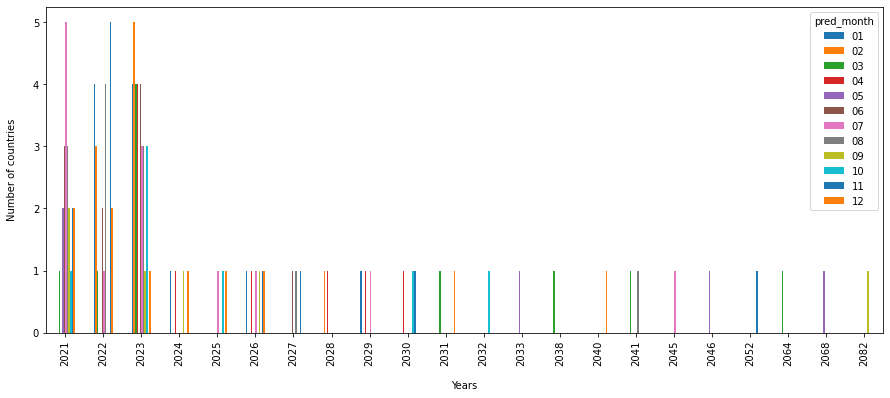

In [43]:
# Graph to see how countries will reach the herd immunity by month and year [2]

ax = pred_70_pivot.plot(kind="bar")

# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()

# Change the plot dimensions (width, height)
fig.set_size_inches(15, 6)

# Change the axes labels
ax.set_xlabel("\nYears")
ax.set_ylabel("Number of countries\n")

In [44]:
# use cumulative sum to determine how many countries will have achieved herd immunity at a given point
pred_70_pivot['sum'] = pred_70_pivot.sum(axis=1)
pred_70_pivot['cumsum'] = pred_70_pivot['sum'].cumsum()

# use this as a percentage of world countries
pred_70_pivot['pcumsum'] = 100 * pred_70_pivot['cumsum']/pred_70_pivot['sum'].sum()
pred_70_pivot.head()

pred_month,01,02,03,04,05,06,07,08,09,10,11,12,sum,cumsum,pcumsum
pred_year,,,,,,,,,,,,,,,
2021,0,0,1,0,2,3,5,3,2,1,2,2,21,21,18.584071
2022,4,3,1,0,0,2,1,4,0,0,5,2,22,43,38.053097
2023,4,5,4,4,0,4,3,3,1,3,0,1,32,75,66.371681
2024,1,0,0,1,0,0,0,0,1,0,0,1,4,79,69.911504
2025,0,0,0,0,0,0,1,0,0,1,0,1,3,82,72.566372


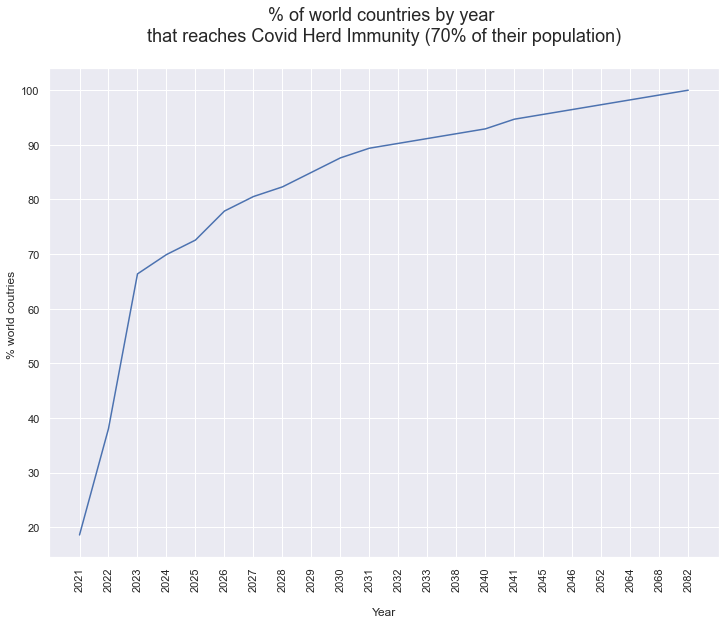

In [45]:
# set style to whitegrid
sns.axes_style("whitegrid")

# set graph size
sns.set(rc={'figure.figsize':(12,9)})

# plot data on x and y
graph = sns.lineplot(x="pred_year", y="pcumsum", data=pred_70_pivot)

# label plot
plt.title("% of world countries by year \nthat reaches Covid Herd Immunity (70% of their population)\n", size=18)
plt.xlabel("\nYear")
plt.ylabel("% world coutries ")
plt.xticks(rotation = 90 )


# show plot
plt.show()

<br>

### Prediction of What Percentage of the Worlds Population Will Have Been Fully Vaccinated by a Provided Date

Implementing univariant linear regression on people_fully_vaccinated by date worldwide. Providing a date, this section will predict what percentage and how many of the worlds population will have been fully vaccinated by this date.
<br>

In [46]:
# read in cleaned dataset to new data frame
vaccination = pd.read_csv('data/cleaned_vaccination.csv')
worldwide_pop = pd.read_csv('data/population_by_country_2020.csv')

In [47]:
# take only the columns of interest
vaccination_6 = vaccination[['date', 'people_fully_vaccinated']]
worldwide_pop = worldwide_pop[['Population (2020)']]

# show their shape
print(vaccination_6.shape)
print(worldwide_pop.shape)

(17607, 2)
(235, 1)


In [48]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_6 = vaccination_6[vaccination_6['people_fully_vaccinated'].notna()]
worldwide_pop = worldwide_pop[worldwide_pop['Population (2020)'].notna()]

# print the new shape
print(vaccination_6.shape)
print(worldwide_pop.shape)

(7185, 2)
(235, 1)


In [49]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_6 = date_to_ordinal_df(vaccination_6)

In [50]:
# take the total world wide number of people vaccinated on each date
world_total_vac_by_date = vaccination_6.groupby(['date']).people_fully_vaccinated.sum().reset_index()

In [51]:
# determine the worlds population
world_pop = worldwide_pop['Population (2020)'].sum()

The mean squared error of this model is 0.026.



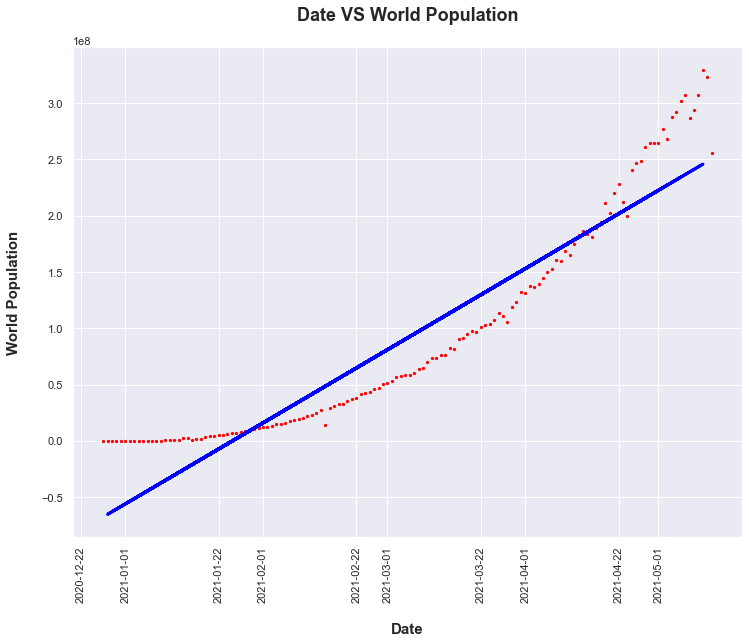

In [52]:
# setup linear regression
LR_world = LinearRegression()

# get X and Y variables
X_world = np.array(world_total_vac_by_date['date']).reshape((-1, 1))
Y_world = np.array(world_total_vac_by_date['people_fully_vaccinated'])
    
# Split the training and test data using 30% for testing
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_world, Y_world, test_size=0.3, random_state=19)
    
# train the model
LR_world.fit(Xtrain, Ytrain)

# test on test set
predictions_world = LR_world.predict(Xtest)

# calculate the mean square error
mse_world = MSE(predictions_world, Ytest, 3)

# show the MSE to determine how accurate the model is
print("The mean squared error of this model is {0}.".format(mse_world))
print()

# set labels
plt.title("Date VS World Population\n",fontsize = 18,fontweight='bold')
plt.ylabel("World Population\n",fontsize = 15,fontweight='bold')
plt.xlabel("\nDate",fontsize = 15,fontweight='bold')

# Plot LR
plot_LR(ordinal_to_datetime_arr(X_world), Y_world, ordinal_to_datetime_arr(Xtest), predictions_world)

In [53]:
# date we want to determine how much of the worlds population is vaccinated on
date_world_str = "05/05/2022"

# change date to ordinal data.
date_world = date_to_ordinal(date_world_str)

# determine the number of people fully vaccinated by this date using linear regression model
world_pop_vac_by = LR_world.intercept_ + LR_world.coef_ * date_world


# determine this as a percentage of the world
percentage_of_people_fully_vaccinated = ((world_pop_vac_by/world_pop)*100)

# print this data
print ("The total percentage of the worlds population fully vaccinated by {0} is predicted to be {1}%, which is {2} people ".format(date_world_str, round(percentage_of_people_fully_vaccinated[0], 2), round(world_pop_vac_by[0])))

The total percentage of the worlds population fully vaccinated by 05/05/2022 is predicted to be 13.82%, which is 1079065128 people 


 <br>

### Prediction of What Date will the population be wholely vaccinated provided the current GDP, Population and vaccination percentage

Implementing multiple linear regression on date by gdp value, population and vaccination percentage (people fully vaccinated per hundred). The purpose is for the machine using the given dataset to predict at what time will a given populace will be fully vaccinated with current gdp, population and current vacination percentage of that populace. 


In [54]:
"""
    Function to predict the number of people in a given country being vaccinated for a given time, vaccination percentage, gdp
    (multivariant regression using population, people fully vaccinated per hundred and gdp vs date)
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
        a gdp value in decimal format
    """
def vaccinated_people_by_pop_gdp(df, pop, percentage, gdp):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        # get X and Y variables
        X = df[['Population (2020)', 'people_fully_vaccinated_per_hundred', '2019']].values
        Y = df['date'].values

        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)

        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('Polulation (millions)')
        ax.set_zlabel('Vaccination%')
        ax.set_ylabel('GDP (trillions)')
        ax.set_title("Population, GDP and Population Percentage Vaccinated by Date\n",fontsize = 18,fontweight='bold')
        
        x = df['Population (2020)']
        y = df['2019']
        z = df['people_fully_vaccinated_per_hundred']
        c = df['date']

        print("Coefficients for:")
        print("\tPopulation (millions)\t: {0:.5f}".format(LR.coef_[0]))
        print("\tVaccination %\t\t: {0:.5f}".format(LR.coef_[1]))
        print("\tGDP (trillion)\t\t: {0:.5f}".format(LR.coef_[2]))
        print("Intercept: ",LR.intercept_)
        print("Scaled MSE value: {:.9f}".format(MSE(predictions, Ytest, 9)))
        print("MSE: {:.2f}".format(metrics.mean_squared_error(predictions, Ytest)))
        print("RMSE: {:.2f}".format(np.sqrt(metrics.mean_squared_error(predictions, Ytest))))
        
        img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()
    
        # return the number of people vaccinated at the given date
        return LR.predict([[pop, percentage, gdp]])

    except:
        # if error has occured let user know
        print("An error has occured")
        return False

In [55]:
vaccination = pd.read_csv('data/cleaned_vaccination.csv')
country_pop = pd.read_csv('data/population_by_country_2020.csv')
country_gdp = pd.read_csv('data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2163564.csv')

# take only the columns of interest
vaccination_7 = vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]
country_pop = country_pop[['Country (or dependency)','Population (2020)']]
country_gdp = country_gdp[['Country Name','2019']]

# merge tables for easier calculation
vac_df = pd.merge(left = vaccination_7, right = country_pop, left_on = 'country', right_on='Country (or dependency)')
vac_df = pd.merge(left = vac_df, right = country_gdp, left_on = 'country', right_on = 'Country Name')

#clear extra columns and na values for people_fully_vaccinated_per_hundred
vac_df = vac_df.drop(['Country (or dependency)', 'Country Name'], axis=1)
vac_df = vac_df[vac_df['people_fully_vaccinated_per_hundred'].notna()]

vac_df = vac_df.dropna()

# change date object to date time and then ordinal to be used in linear regression
vac_df = date_to_ordinal_df(vac_df)
    

vac_df['Population (2020)'] = vac_df['Population (2020)'] / (10**6)
vac_df['2019'] = vac_df['2019']/(10**12)

In [56]:
# take just numerical columns and determine Z-score in new data frame called z-scores
z_score_cols = vac_df[['people_fully_vaccinated_per_hundred', 'Population (2020)','2019']].copy()

z_scores = pd.DataFrame(stats.zscore(z_score_cols, nan_policy='omit'))

print(z_scores[z_scores > np.abs(3.0)].count())

vac_df = vac_df[(np.abs(stats.zscore(vac_df.select_dtypes(exclude='object'))) < 3).all(axis=1)]

0    146
1     86
2    116
dtype: int64


Coefficients for:
	Population (millions)	: 0.09712
	Vaccination %		: 2.50279
	GDP (trillion)		: -5.97426
Intercept:  737862.8303318857
Scaled MSE value: 0.000000002
MSE: 905.75
RMSE: 30.10


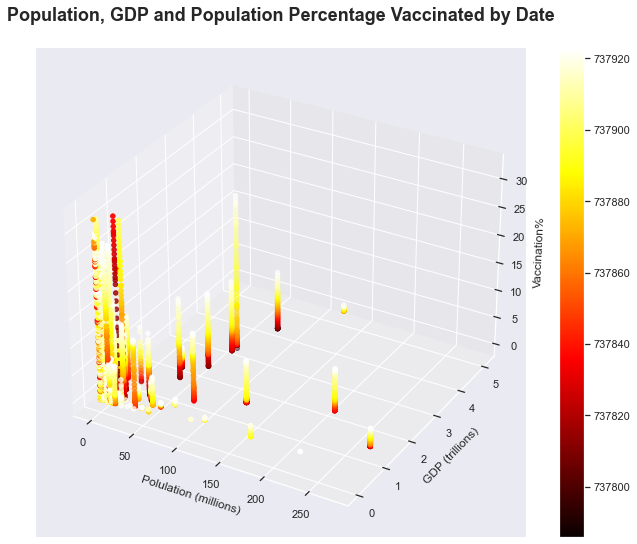

By 2021-09-28, 70% of the 330 million population, with a GDP of 1.40 trillion will be vaccinated


In [57]:
# determine a popualtion
pop_multi = 330
# determine the desired percentage
percent_multi = 70
# determine the  gdp
gdp_multi = 1.4

date_multi = vaccinated_people_by_pop_gdp(vac_df, pop_multi, percent_multi, gdp_multi)

date_multi = ordinal_to_datetime(int(date_multi))
print("By {0}, {3}% of the {1} million population, with a GDP of {2:.2f} trillion will be vaccinated".format(date_multi, pop_multi, gdp_multi, percent_multi))

# References

1. Stackoverflow (2014, Aug. 5). <i>Extracting just Month and Year separately from Pandas Datetime column</i> [Forum]. Available: https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column
2. Stackoverflow (2017, Dec. 13). <i>Grouped bar plot</i> [Forum]. Available: https://stackoverflow.com/questions/47796264/function-to-create-grouped-bar-plot/47797080#47797080

